# XGBoost Parameter Tuning for Otto Dataset

## 1. 直接调用xgboost内嵌的cv寻找最佳的参数n_estimators

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，进行XGBoost参数调优探索。

竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

首先 import 必要的模块

Install xgboost from linux
 pip install -i  https://mirrors.ustc.edu.cn/pypi/web/simple xgboost
 

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [2]:
# path to where the data lies
dpath = '../data/'
train = pd.read_csv(dpath +"Otto_train.csv")
train.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


## Variable Identification

选择该数据集是因为的数据特征单一，我们可以在特征工程方面少做些工作，集中精力放在参数调优上

## Target 分布，看看各类样本分布是否均衡

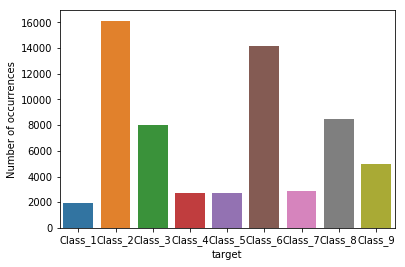

In [3]:
sns.countplot(train.target);
pyplot.xlabel('target');
pyplot.ylabel('Number of occurrences');

每类样本分布不是很均匀

In [4]:
# drop ids and get labels
y_train = train['target']
y_train = y_train.map(lambda s: s[6:]) 
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
X_train = np.array(train)

In [5]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

默认参数，此时学习率为0.1，比较大，观察弱分类数目的大致范围
（采用默认参数配置，看看模型是过拟合还是欠拟合）

In [6]:
#直接调用xgboost内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证
def modelfit(alg, X_train, y_train, cv_folds=None, early_stopping_rounds=10):
    xgb_param = alg.get_xgb_params()
    xgb_param['num_class'] = 9
    
    #直接调用xgboost，而非sklarn的wrapper类
    xgtrain = xgb.DMatrix(X_train, label = y_train)
        
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
             metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
  
    cvresult.to_csv('1_nestimators.csv', index_label = 'n_estimators')
    
    #最佳参数n_estimators
    n_estimators = cvresult.shape[0]
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = n_estimators)
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)

   #Print model report:
    print ("logloss of train :",logloss)

In [7]:
#params = {"objective": "multi:softprob", "eval_metric":"mlogloss", "num_class": 9}
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3)

modelfit(xgb1, X_train, y_train, cv_folds = kfold)

/root/.local/lib/python3.6/site-packages/xgboost-0.81-py3.6.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


logloss of train : 0.26988290069450915


/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


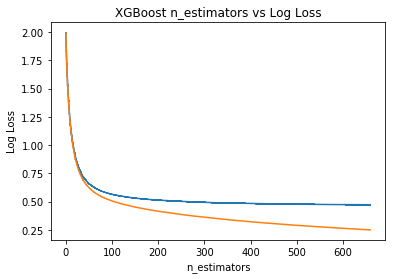

In [8]:
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')
        
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(0, cvresult.shape[0])
        
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators4_1.png' )

pyplot.show()

/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


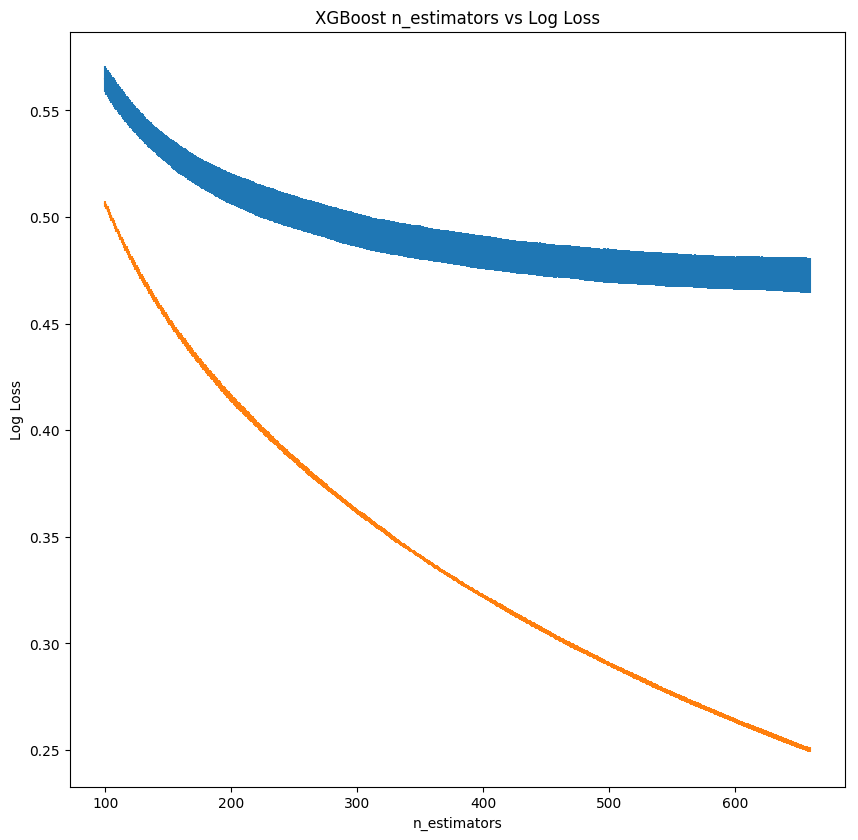

In [9]:
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')

cvresult = cvresult.iloc[100:]
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(100,cvresult.shape[0]+100)
        
fig = pyplot.figure(figsize=(10, 10), dpi=100)
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators_detail.png' )

pyplot.show()